In [1]:
# load the relevant modules for the analysis

import os
from pathlib import Path

import emcee
import numpy as np
import pandas as pd

from pl_temp_fit import config_utils

os.chdir("/media/mohammed/Work/Work/pl_temp_fit/")
# access the right directory
# os.chdir('C:\\Users\\ma11115\\OneDrive - Imperial College London\\pl_temp_fit')

In [2]:
databse_path = Path("fit_experimental_emcee_el/fit_data_base/")
json_files = list(databse_path.glob("*.json"))
list_model_config = []
for id, json_file in enumerate(json_files):
    model_config, model_config_save = config_utils.load_model_config(
        json_file.name.replace(".json", ""),
        database_folder=databse_path,
    )

    if Path(model_config_save["save_folder"] + "/sampler.h5").exists():
        filename = model_config_save["save_folder"] + "/sampler.h5"
        try:
            reader = emcee.backends.HDFBackend(filename, name="multi_core")
            distribution = reader.get_chain(flat=True)
        except AttributeError:
            print("checking if the file contains single core data")
            reader = emcee.backends.HDFBackend(filename, name="single_core")
            distribution = reader.get_chain(flat=True)
        true_parameters = list(np.mean(distribution, axis=0))
        model_config_save["mean"] = [f"{x:.3f}" for x in true_parameters]
        model_config_save["num_iteration"] = reader.iteration
        log_prob = reader.get_log_prob(flat=True)
        model_config_save["max_log_prob"] = np.max(log_prob)

        list_model_config.append(model_config_save)

df_all = pd.DataFrame(list_model_config)
df_all.sort_values(by="date", ascending=False, inplace=True)
df_all[["csv_name_pl", "num_iteration", "max_log_prob"]]

,csv_name_pl,num_iteration,max_log_prob
0,/media/mohammed/Work/Work/pl_temp_fit/experiem...,593,-458.195769


In [23]:
index_analyse = 0
test_id = df_all["test_id"].loc[index_analyse]
model_config, model_config_save = config_utils.load_model_config(
    test_id, database_folder=databse_path
)
filename = model_config_save["save_folder"] + "/sampler.h5"
reader = emcee.backends.HDFBackend(filename, name="multi_core")
distribution = reader.get_chain(discard=0, flat=True)

number of iterations 662
-1617.8681751981267


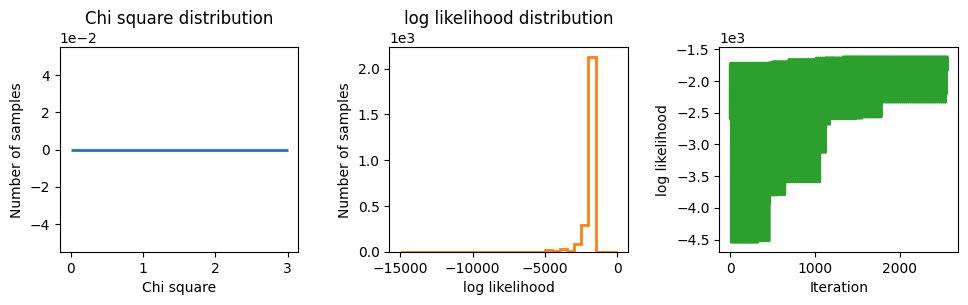

In [30]:
from pl_temp_fit import plot_utils
import importlib

importlib.reload(plot_utils)
plot_utils.plot_fit_statistics(
    reader,
    range_log_prior=(-15000, 0),
    discard=550,
    range_chi_square=(0, 3),
    filter_log_likelihood=True,
)

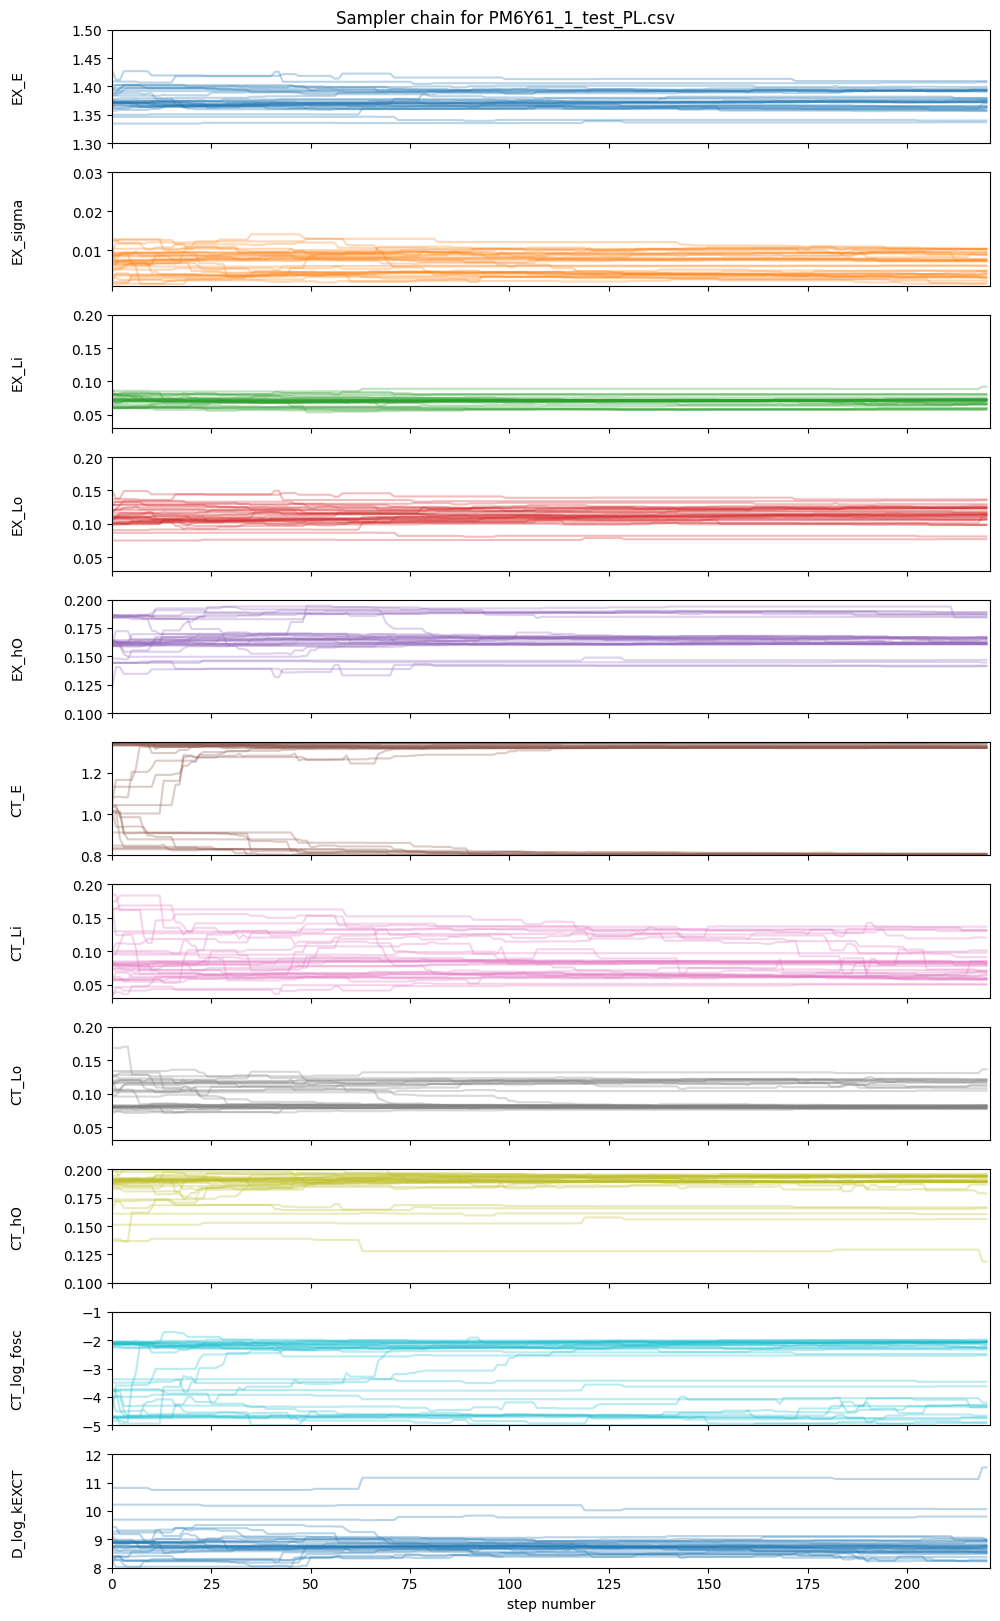

In [33]:
plot_utils.plot_chains(reader, model_config_save, discard=500)

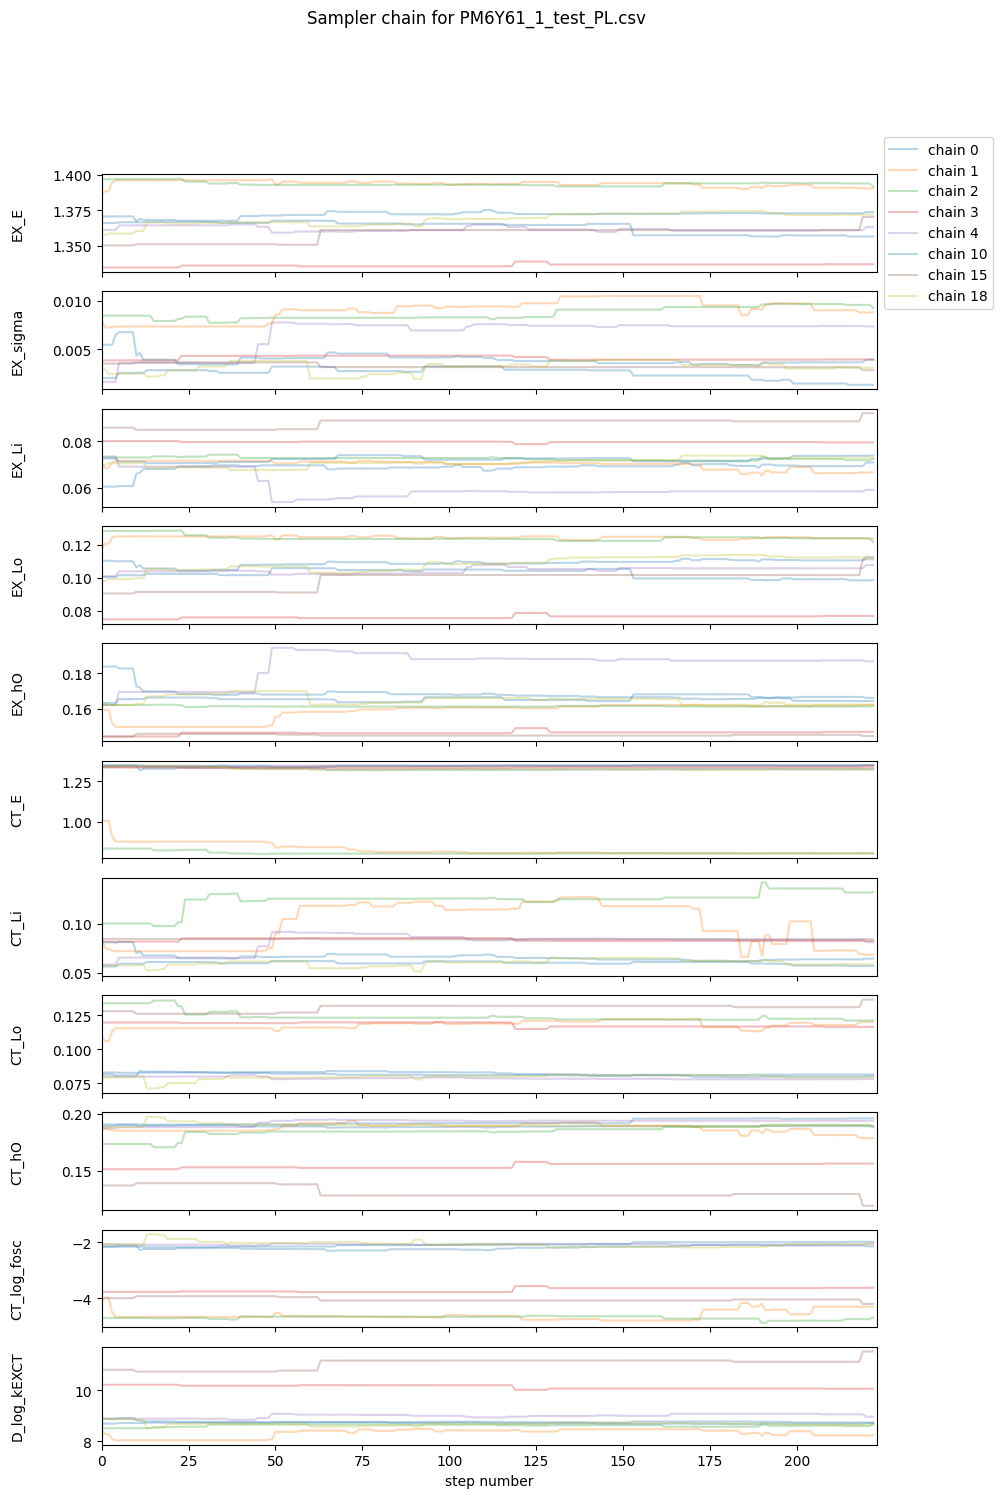

In [36]:
plot_utils.plot_diff_chains(
    reader,
    model_config_save,
    discard=500,
    chains_list=[0, 1, 2, 3, 4, 10, 15, 18],
)

(1.0, 1.6)

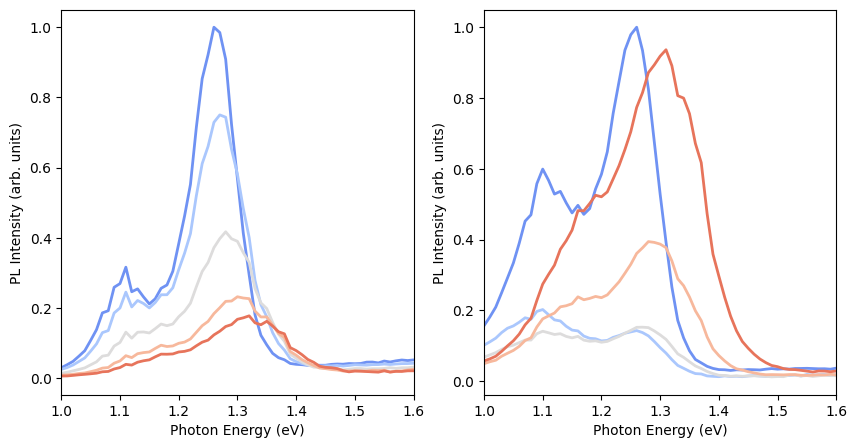

In [37]:
from pl_temp_fit import Exp_data_utils
import matplotlib.pyplot as plt


def plot_plel_data(
    truemodel_pl,
    truemodel_el,
    temperature_list_pl,
    hws_pl,
    temperature_list_el,
    hws_el,
    title="Experimental Data",
):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    data_true_plot_pl = truemodel_pl.reshape(len(hws_pl), -1) / max(
        truemodel_pl.reshape(-1, 1)
    )
    data_true_plot_el = truemodel_el.reshape(len(hws_el), -1) / max(
        truemodel_el.reshape(-1, 1)
    )

    import seaborn as sns

    color_list = sns.color_palette("coolwarm", len(temperature_list_pl))
    for i in range(len(temperature_list_pl)):
        ax[0].plot(
            hws_pl,
            data_true_plot_pl[:, i],
            label="" + str(temperature_list_pl[i]) + " K",
            # linestyle="--",
            color=color_list[i],
            linewidth=2,
        )
    for i in range(len(temperature_list_el)):
        ax[1].plot(
            hws_el,
            data_true_plot_el[:, i],
            label="" + str(temperature_list_el[i]) + " K",
            # linestyle="--",
            color=color_list[i],
            linewidth=2,
        )
    ax[0].set_xlabel("Photon Energy (eV)")
    ax[0].set_ylabel("PL Intensity (arb. units)")
    ax[1].set_xlabel("Photon Energy (eV)")
    ax[1].set_ylabel("PL Intensity (arb. units)")

    return fig, ax


Exp_data_pl, temperature_list_pl, hws_pl = Exp_data_utils.read_data(
    model_config_save["csv_name_pl"]
)
Exp_data_el, temperature_list_el, hws_el = Exp_data_utils.read_data(
    model_config_save["csv_name_el"]
)
fig, ax = plot_plel_data(
    Exp_data_pl,
    Exp_data_el,
    temperature_list_pl,
    hws_pl,
    temperature_list_el,
    hws_el,
    title="Experimental Data",
)
ax[0].set_xlim(1, 1.6)
ax[1].set_xlim(1, 1.6)

{'EX': {'E': np.float64(1.3906929361963256),
  'sigma': np.float64(0.009579189296215257),
  'Li': np.float64(0.07283459539102319),
  'Lo': np.float64(0.11962944291455233),
  'hO': np.float64(0.16027917117981666)},
 'CT': {'E': np.float64(0.8231921647888176),
  'Li': np.float64(0.15223233805984843),
  'Lo': np.float64(0.11446896090815765),
  'hO': np.float64(0.19702656413924535),
  'log_fosc': np.float64(-4.6449016449418306)},
 'D': {'log_kEXCT': np.float64(8.714073850258595)}}

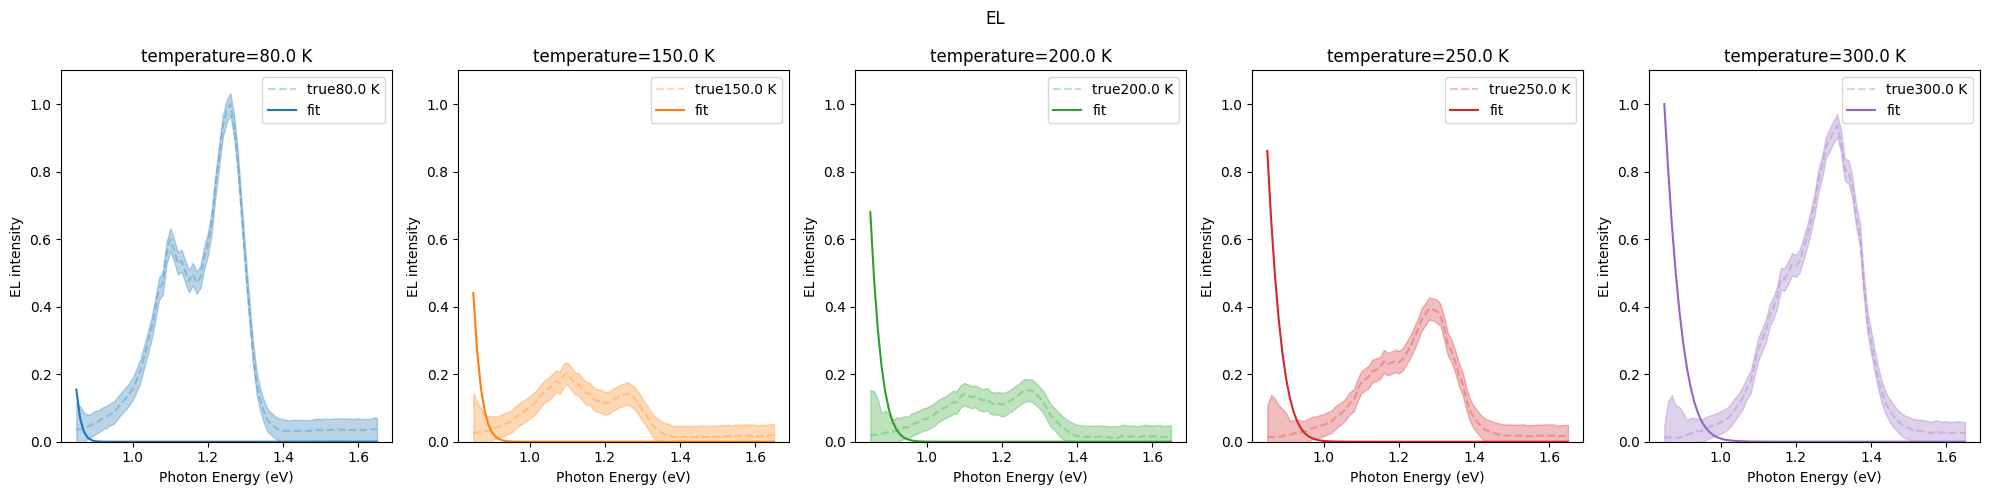

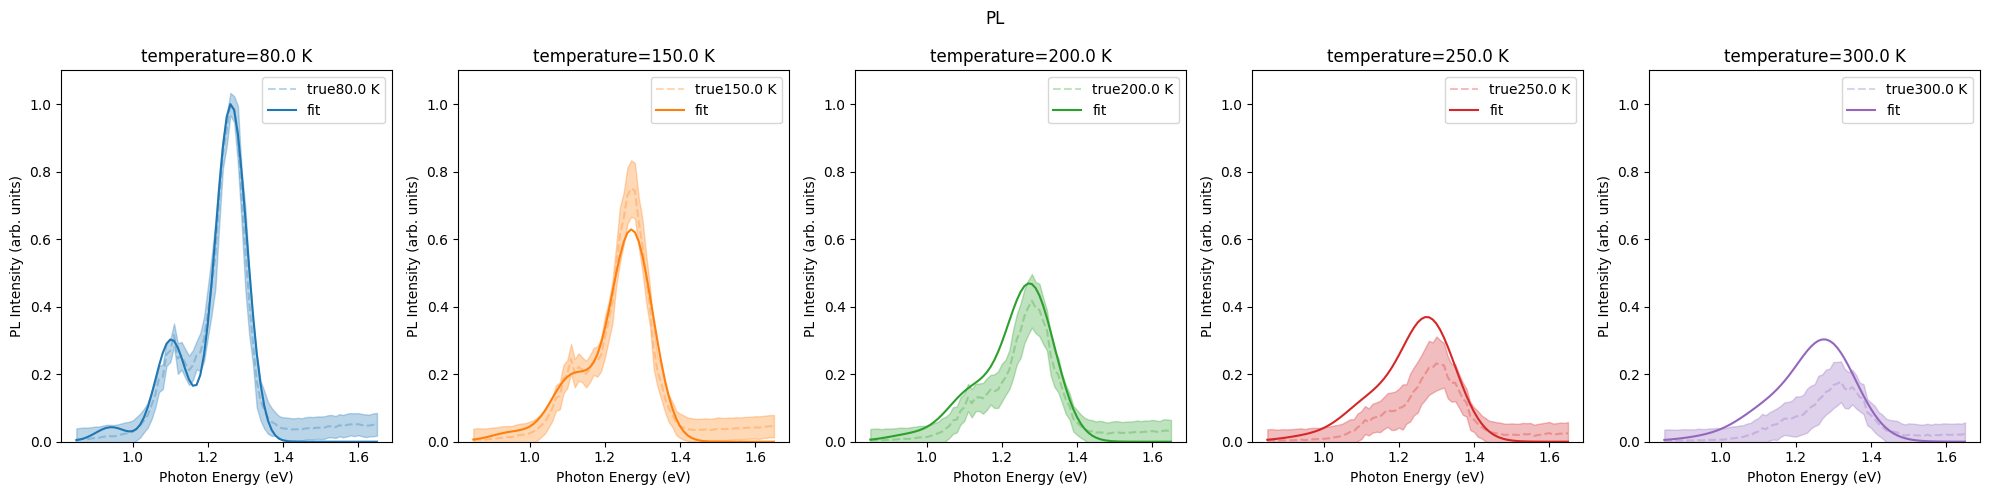

In [39]:
import importlib
from pl_temp_fit import fit_el_utils, generate_data_utils, covariance_utils

importlib.reload(fit_el_utils)
importlib.reload(generate_data_utils)


def plot_fit_results(reader,model_config_save,model_config,discard=0):
    # Load the model config

    Exp_data_pl, temperature_list_pl, hws_pl = Exp_data_utils.read_data(
        model_config_save["csv_name_pl"]
    )
    Exp_data_el, temperature_list_el, hws_el = Exp_data_utils.read_data(
        model_config_save["csv_name_el"]
    )
    sample = reader.get_chain(discard=discard, flat=True)
    sample_num = np.random.randint(0, sample.shape[0])
    data_fit = sample[sample_num, :]
    true_parameters = fit_el_utils.get_param_dict(
        model_config_save['params_to_fit_init'], data_fit
    )

    fixed_parameters_dict, params_to_fit_init, min_bounds, max_bounds = (
        config_utils.get_dict_params(model_config_save)
    )
    model_config["temperature_list_el"] = temperature_list_el
    model_config["hws_el"] = hws_el
    model_config["temperature_list_pl"] = temperature_list_pl
    model_config["hws_pl"] = hws_pl
    co_var_mat_pl, co_var_mat_el, variance_el, variance_pl = (
        covariance_utils.get_covariance_matrix_for_data(
            model_config,
            fixed_parameters_dict=fixed_parameters_dict,
            params_to_fit=true_parameters,
        )
    )
    fit_el_utils.plot_exp_data_with_variance(
        temperature_list_el,
        hws_el,
        temperature_list_pl,
        hws_pl,
        variance_el,
        variance_pl,
        model_config_save['save_folder'],
        fixed_parameters_dict,
        true_parameters,
        Exp_data_pl,
        Exp_data_el,
    )
    return true_parameters


true_parameters = plot_fit_results(reader,model_config_save,model_config, discard=550)
true_parameters

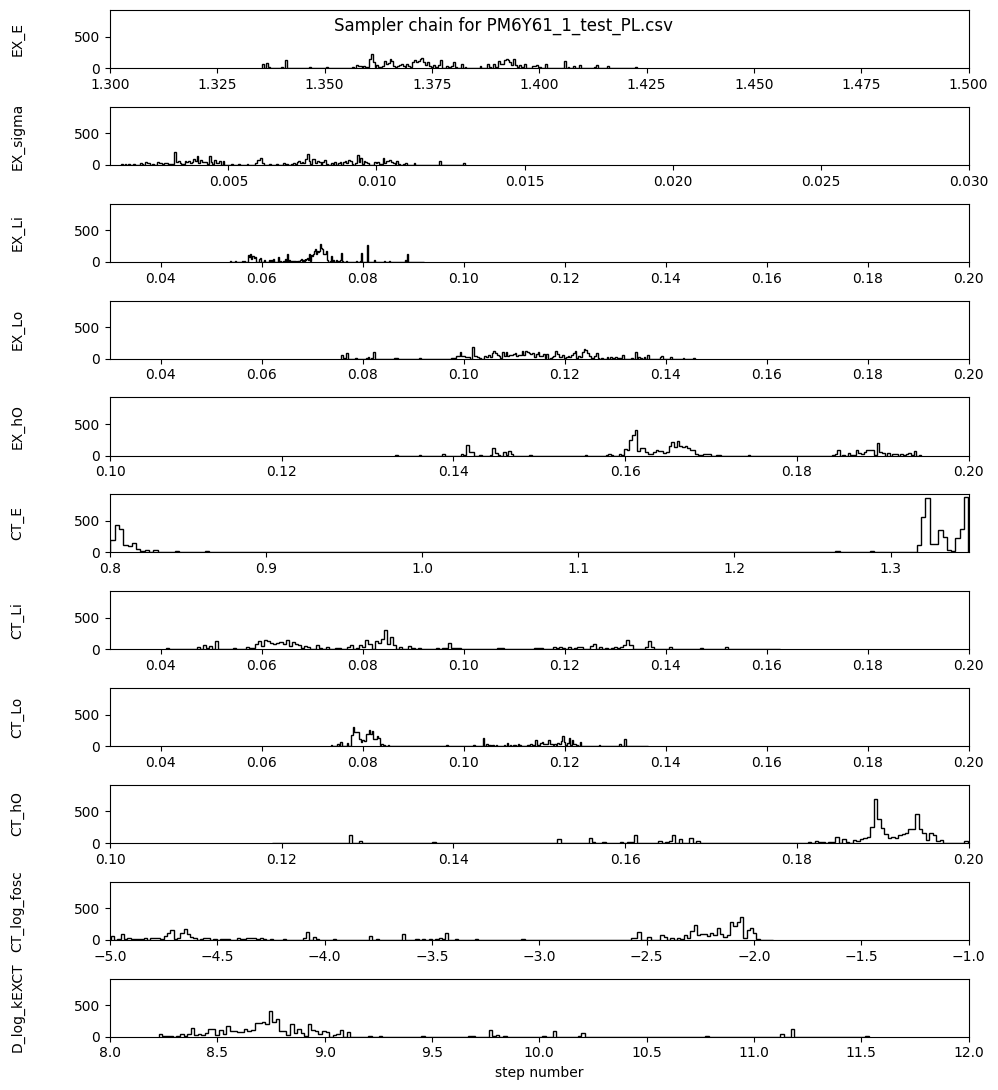

In [38]:
def plot_distribution(reader,model_config_save,discard = 0,set_axis_limits=True):

    samples = reader.get_chain(discard=discard,flat=True)
    labels=[]
    min_bound, max_bound = {}, {}
    params_to_fit = model_config_save['params_to_fit_init']
    for key in params_to_fit.keys():
        for keys in params_to_fit[key].keys():
            labels.append(f"{key}_{keys}")
            min_bound[f"{key}_{keys}"] = model_config_save["min_bounds"][key][keys]
            max_bound[f"{key}_{keys}"] = model_config_save["max_bounds"][key][keys]
    ndim = len(labels)
    fig, axes = plt.subplots(ndim, figsize=(10, ndim*1),sharey=True)
    for i in range(ndim):
        ax = axes[i]
        ax.hist(samples[:, i], 200, color="k", histtype="step")
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)
        ax.set_xlim(
            min_bound[ax.get_ylabel()], max_bound[ax.get_ylabel()]
        )
    axes[-1].set_xlabel("step number")
    fig.tight_layout()
    fig.suptitle(f"Sampler chain for {model_config_save['csv_name_pl'].split('/')[-1]}")    

    fig.show()
plot_distribution(reader,model_config_save,discard=550)

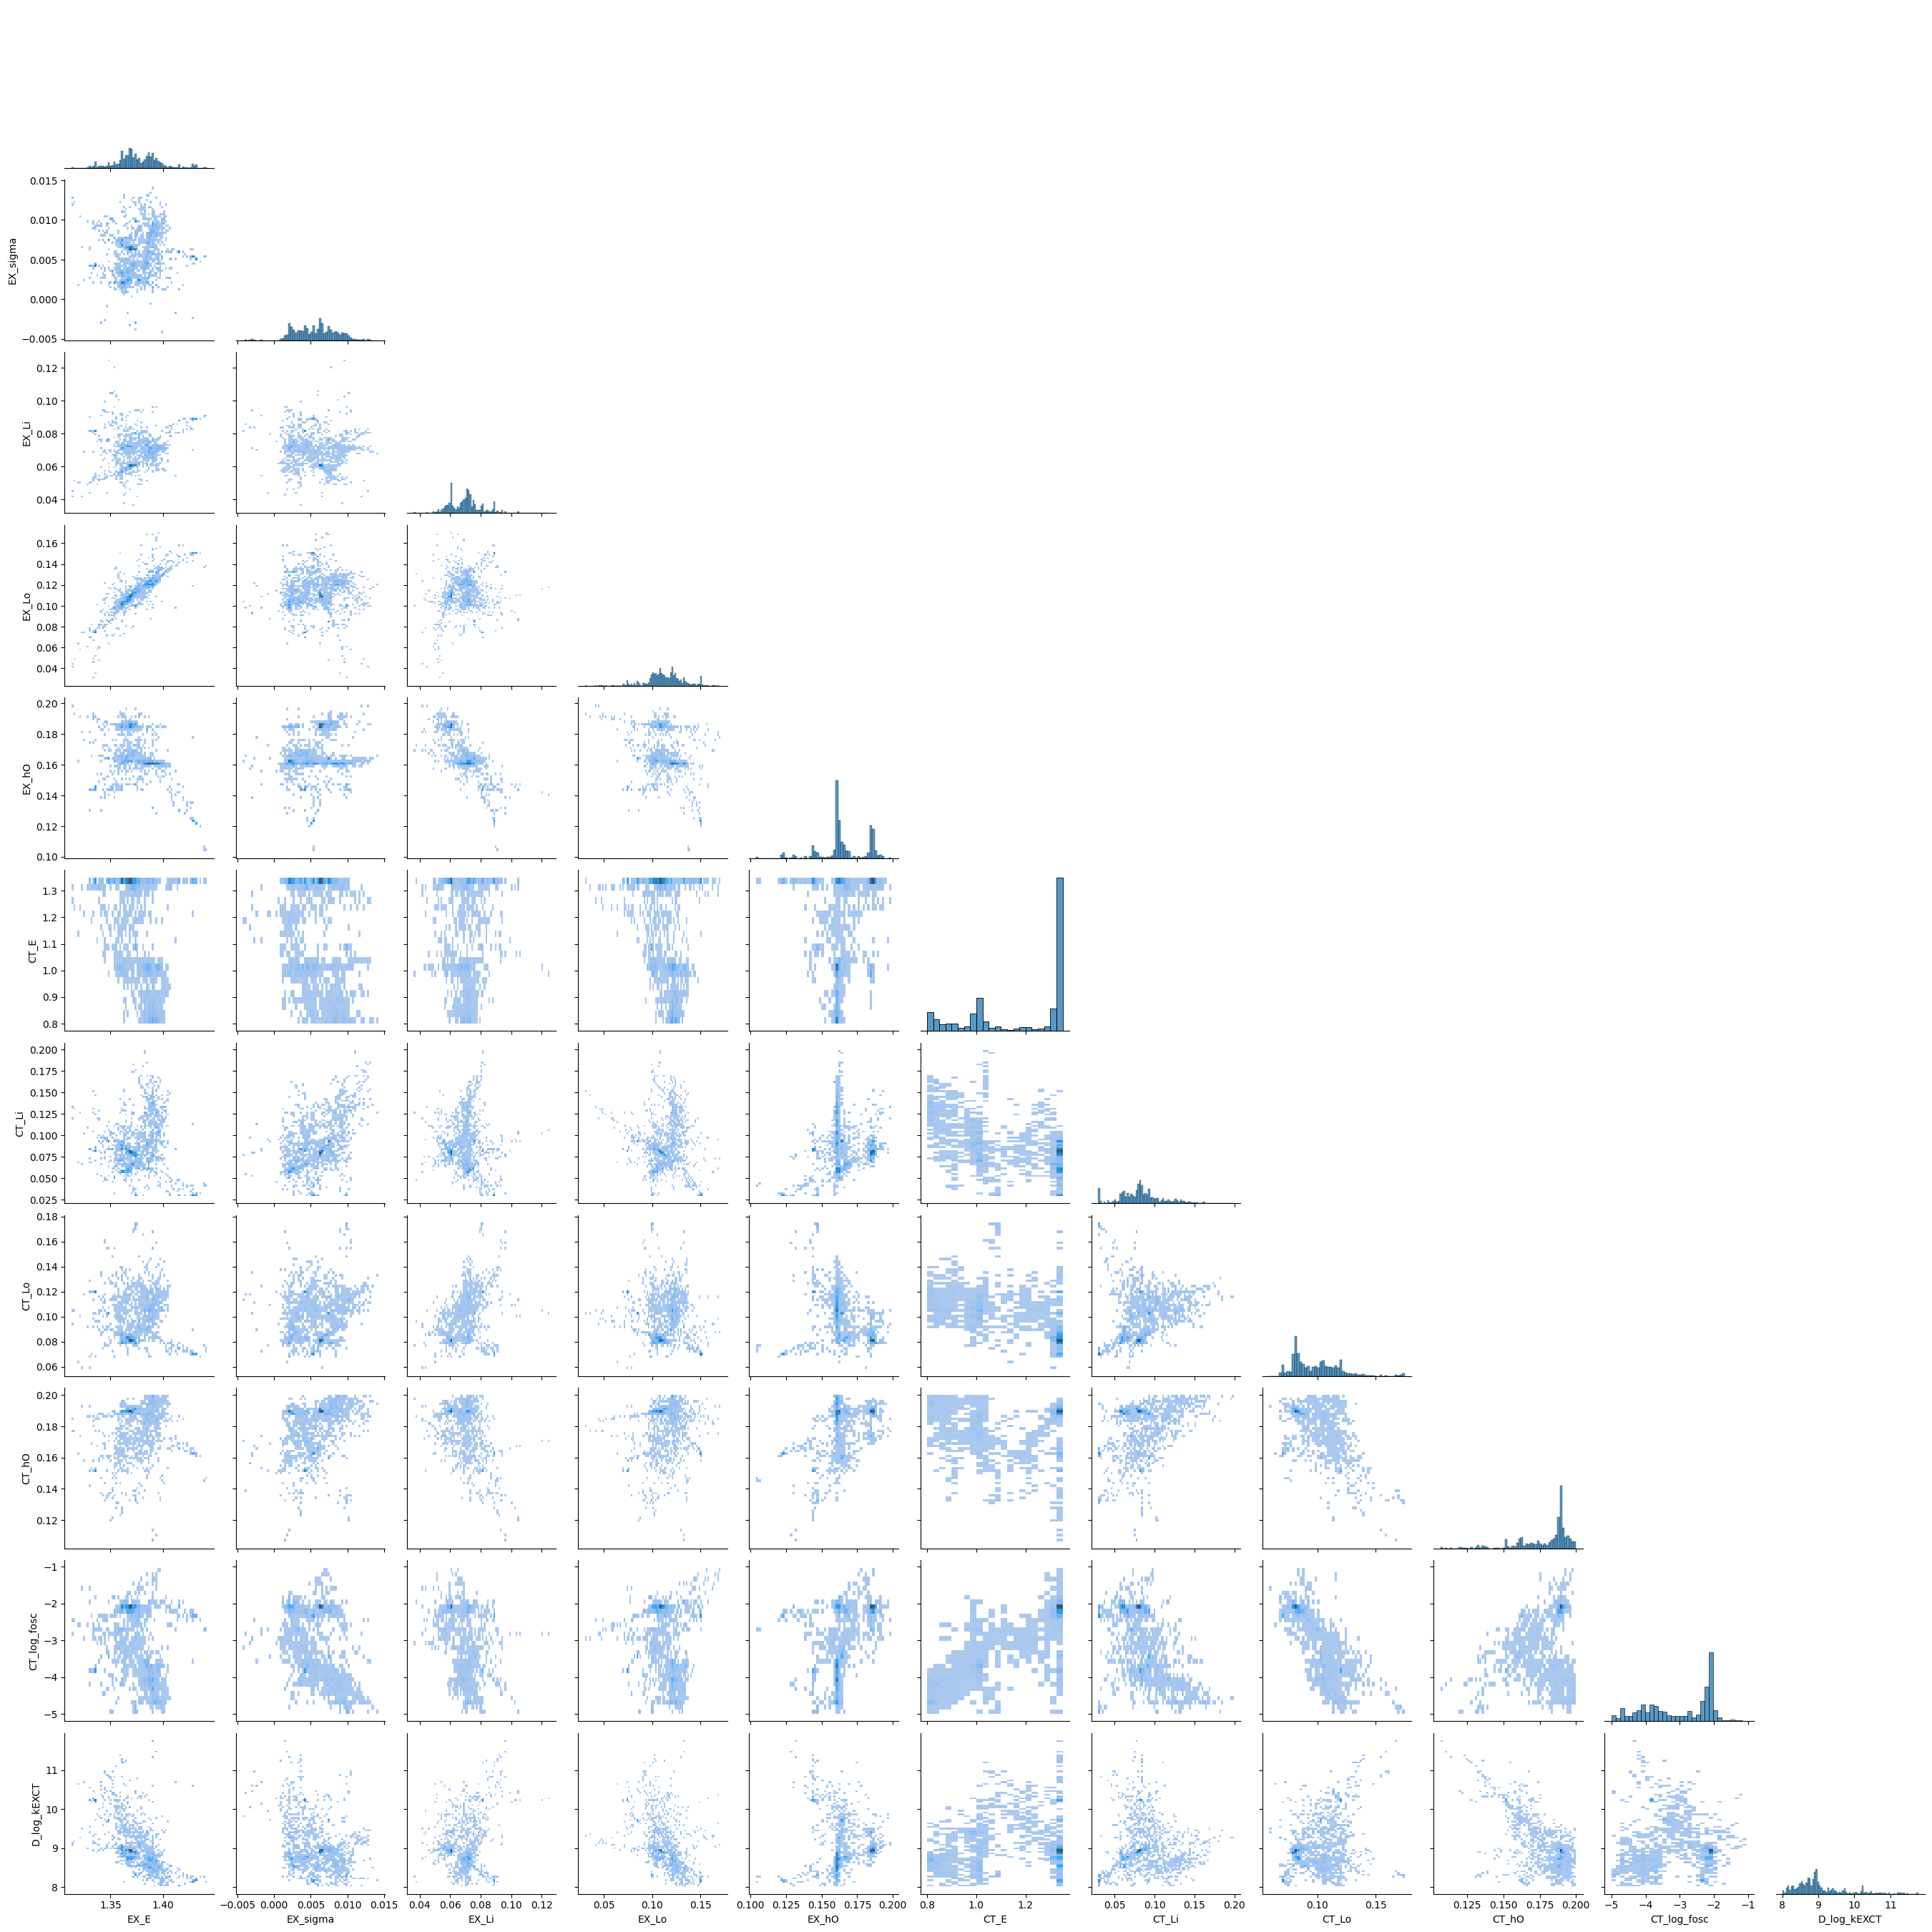

In [11]:
# plot a pair grid plot
import seaborn as sns


# plot posterior predictive
def plot_pair_plot(reader,model_config_save, discard=0, set_axis_limits=True):

    samples = reader.get_chain(discard=discard, flat=True)
    labels = []
    min_bound, max_bound = {}, {}
    params_to_fit = model_config_save['params_to_fit_init']
    for key in params_to_fit.keys():
        for keys in params_to_fit[key].keys():
            labels.append(f"{key}_{keys}")
            min_bound[f"{key}_{keys}"] = model_config_save["min_bounds"][key][keys]
            max_bound[f"{key}_{keys}"] = model_config_save["max_bounds"][key][keys]

    ndim = len(labels)
    df_samples = pd.DataFrame(samples, columns=labels)
    g = sns.pairplot(df_samples, kind="hist", corner=True)
    if set_axis_limits:
        for i, ax in enumerate(g.figure.axes):
            if ax.get_xlabel() in min_bound:
                ax.set_xlim(
                    min_bound[ax.get_xlabel()], max_bound[ax.get_xlabel()]
                )
            if ax.get_ylabel() in min_bound:
                ax.set_ylim(
                    min_bound[ax.get_ylabel()], max_bound[ax.get_ylabel()]
                )
    g.figure.show()
    return g


g = plot_pair_plot(reader,model_config_save, discard=0, set_axis_limits=False)

number of iterations 628


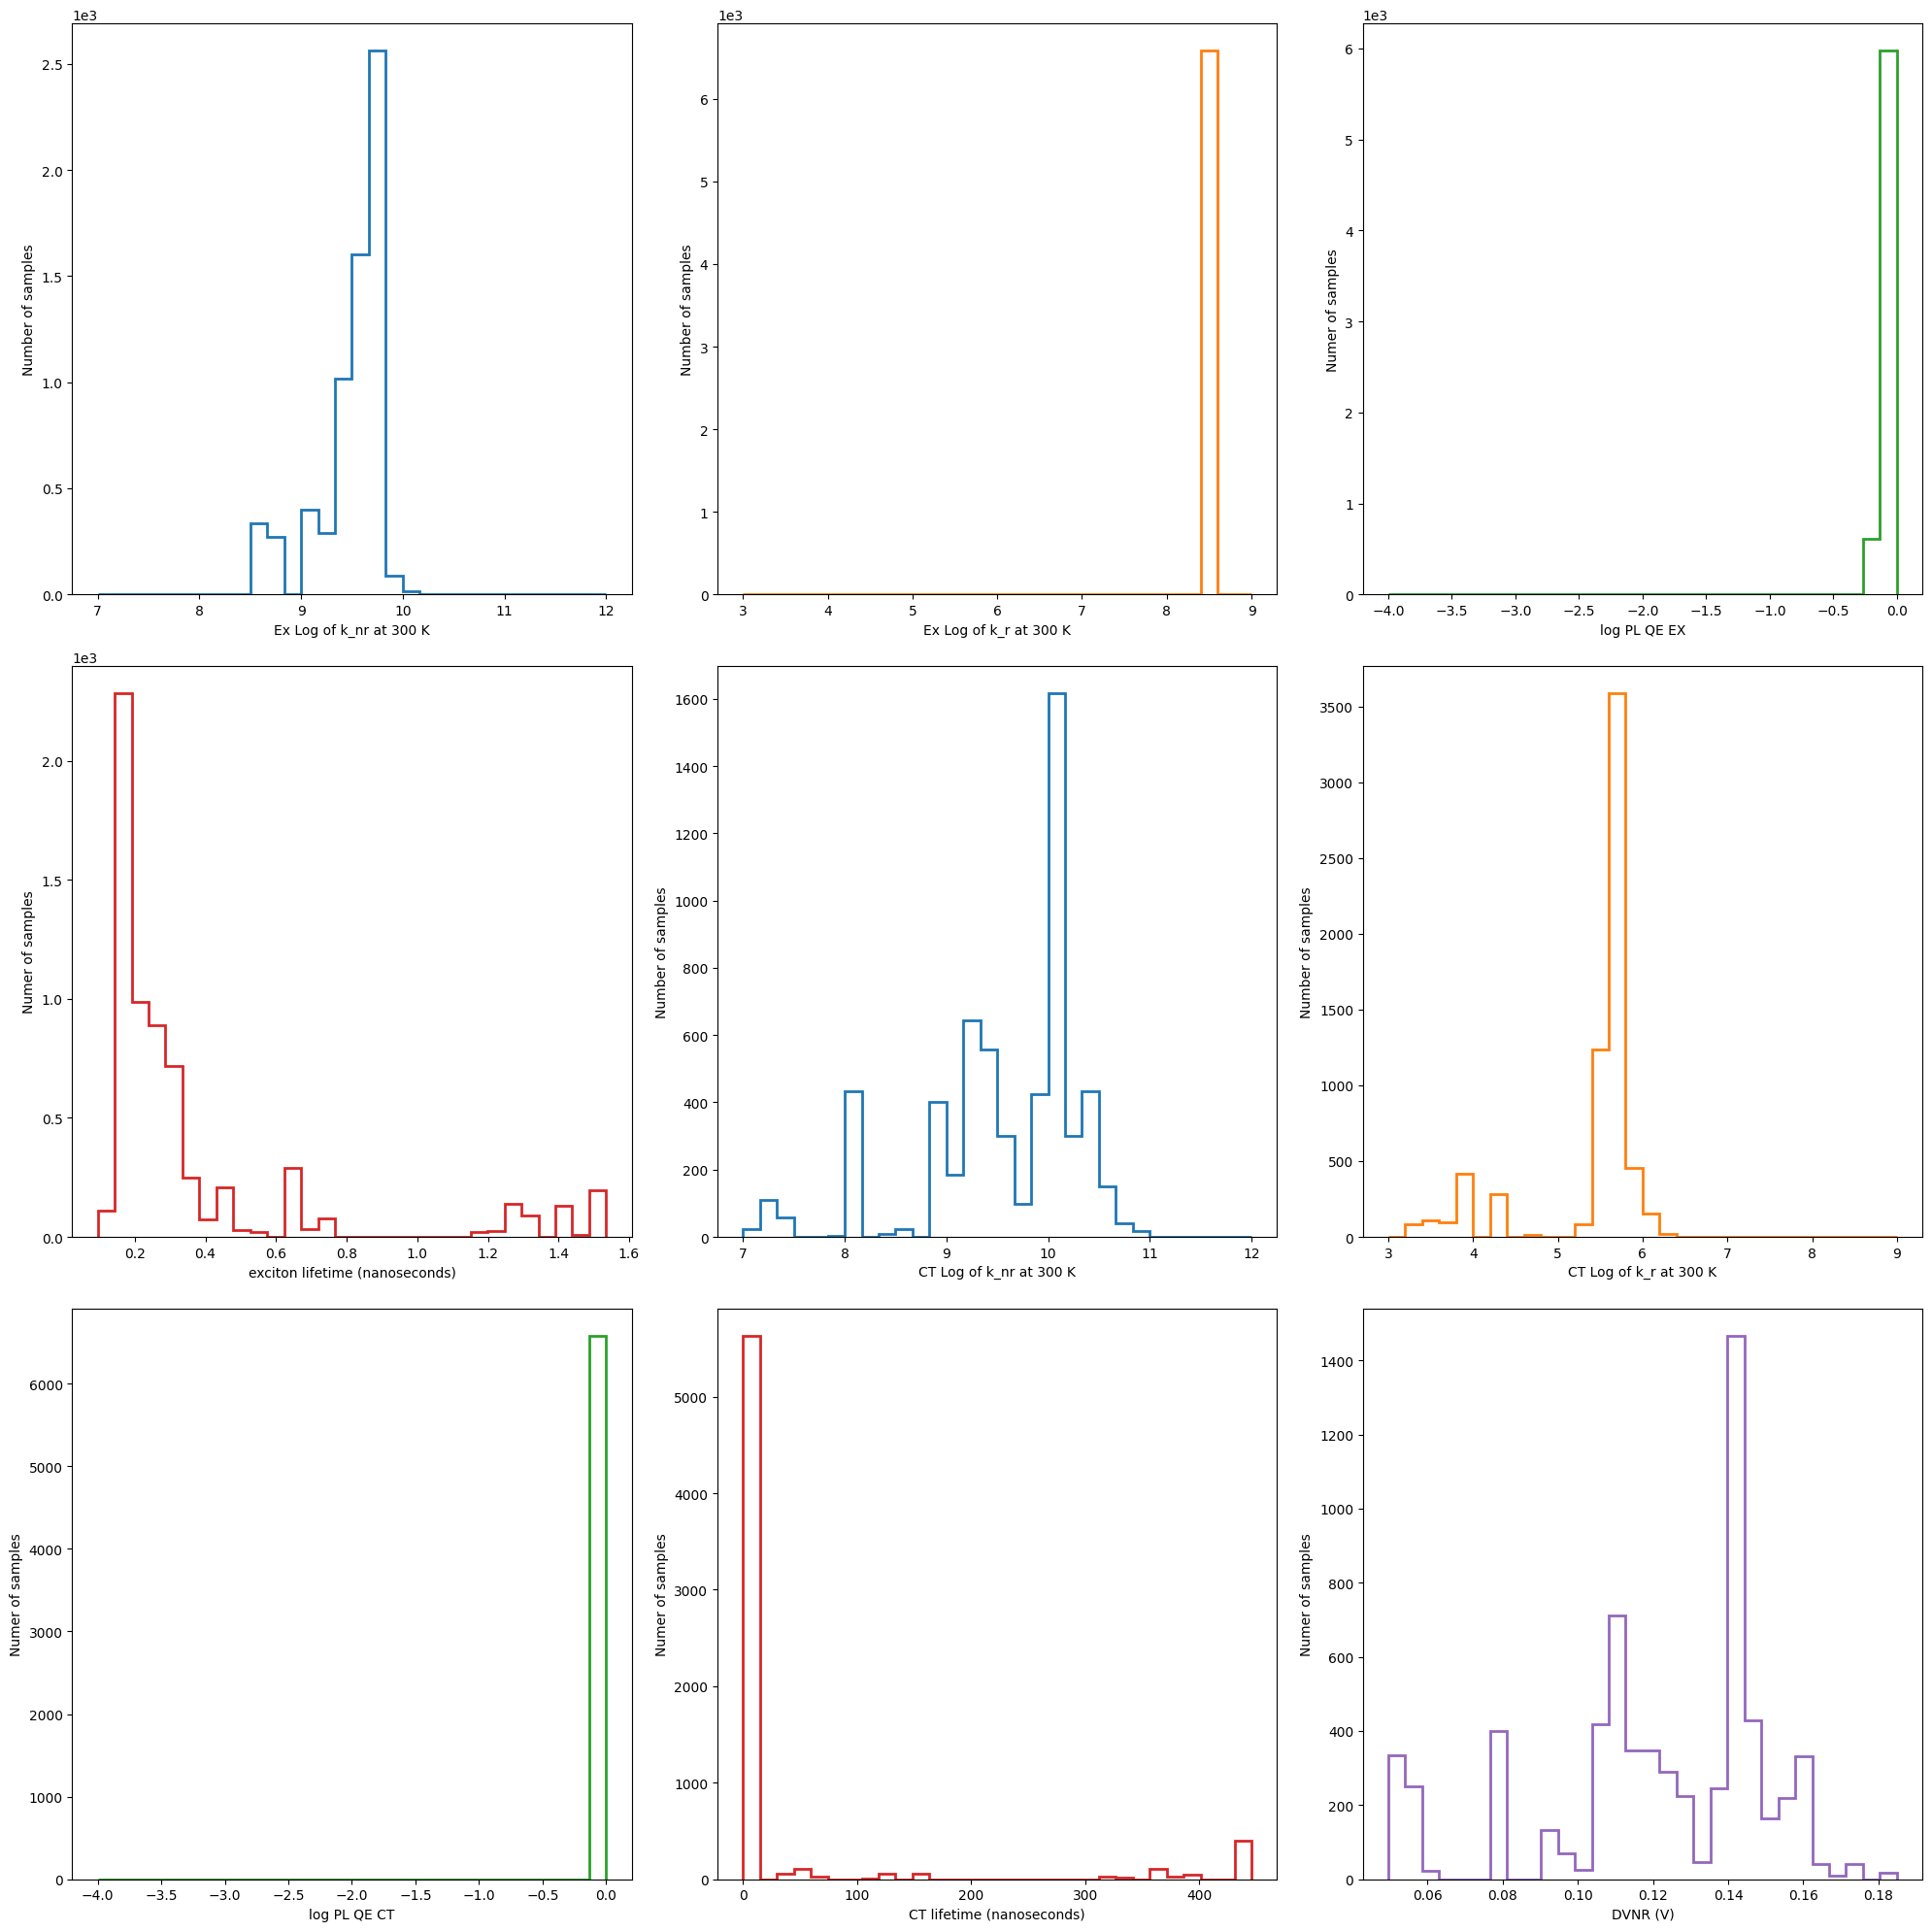

In [13]:

def plot_voltage_losses(
    reader,
    range_chi_square=(7, 11),
    range_log_prior=(7, 11),
    discard=5,
    temperature=300,
    filter_log_likelihood=False,
):
    """plot the lifetime distribution from the sampling output
    reader: the reader object from the emcee sampler
    range_chi_square: the range for the chi square plot
    range_log_prior: the range for the log prior plot
    discard: the number of samples to discard
    temperature: the temperature at which the lifetime is calculated
    """
    print("number of iterations", reader.iteration)
    blobs = reader.get_blobs(flat=True, discard=discard)
    if filter_log_likelihood:
        blobs = blobs[
            blobs["log_likelihood"] > max(blobs["log_likelihood"]) * 3
        ]
    fig, ax = plt.subplots(3, 3, figsize=(20, 20))

    ax = ax.flatten()
    ax[0].hist(
        np.log10(blobs["EX_knr"]),
        30,
        histtype="step",
        range=(7,12),
        color="C" + str(0),
        linewidth=2,
    )
    ax[0].set_xlabel("Ex Log of k_nr at " + str(temperature) + " K")
    ax[0].set_ylabel("Number of samples")
    ax[1].hist(
        np.log10(blobs["EX_kr"]),
        30,
        histtype="step",
        range=(3,9),
        color="C" + str(1),
        linewidth=2,
    )
    ax[1].set_xlabel("Ex Log of k_r at " + str(temperature) + " K")
    ax[1].set_ylabel("Number of samples")
    pl_QE = blobs["EX_knr"] / (blobs["EX_kr"] + blobs["EX_knr"])
    ax[2].hist(
        np.log10(pl_QE),
        30,
        histtype="step",
        range=(-4, 0),
        color="C" + str(2),
        linewidth=2,
    )
    ax[2].set_xlabel("log PL QE EX")
    ax[2].set_ylabel("Numer of samples")
    lifetime = 1 / (blobs["EX_kr"] + blobs["EX_knr"])
    ax[3].hist(
        lifetime * 1e9,
        30,
        histtype="step",
        color="C" + str(3),
        linewidth=2,
    )
    ax[3].set_xlabel("exciton lifetime (nanoseconds)")
    ax[3].set_ylabel("Numer of samples")
    # do the same thing for the CT
    ax[4].hist(
        np.log10(blobs["CT_knr"]),
        30,
        histtype="step",
        range=(7,12),
        color="C" + str(0),
        linewidth=2,
    )
    ax[4].set_xlabel("CT Log of k_nr at " + str(temperature) + " K")
    ax[4].set_ylabel("Number of samples")
    ax[5].hist(
        np.log10(blobs["CT_kr"]),
        30,
        histtype="step",
        range=(3,9),
        color="C" + str(1),
        linewidth=2,
    )
    ax[5].set_xlabel("CT Log of k_r at " + str(temperature) + " K")
    ax[5].set_ylabel("Number of samples")
    pl_QE = blobs["CT_knr"] / (blobs["CT_kr"] + blobs["CT_knr"])
    ax[6].hist(
        np.log10(pl_QE),
        30,
        histtype="step",
        range=(-4, 0),
        color="C" + str(2),
        linewidth=2,
    )
    ax[6].set_xlabel("log PL QE CT")
    ax[6].set_ylabel("Numer of samples")
    lifetime = 1 / (blobs["CT_kr"] + blobs["CT_knr"])
    ax[7].hist(
        lifetime * 1e9,
        30,
        histtype="step",
        color="C" + str(3),
        linewidth=2,
    )
    ax[7].set_xlabel("CT lifetime (nanoseconds)")
    ax[7].set_ylabel("Numer of samples")
    ax[8].hist(
        blobs["DVNR"],
        30,
        histtype="step",
        color="C" + str(4),
        linewidth=2,
    )
    ax[8].set_xlabel("DVNR (V)")
    ax[8].set_ylabel("Numer of samples")
    # set y ticks to exponent form
    for i in range(4):
        ax[i].ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    fig.tight_layout()
    plt.show()
plot_voltage_losses(reader, discard=100, filter_log_likelihood=True)
